In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

drive_dir = "/content/drive/MyDrive/"
data_dir = os.path.join(drive_dir, "colab", "CNU_AI_TEAMWORK", "Term_Dataset") # 자신의 환경에 맞게끔 경로를 셋팅해주세요.
data_dir

'/content/drive/MyDrive/colab/CNU_AI_TEAMWORK/Term_Dataset'

구글 드라이브 마운트 & 경로 셋팅

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow import keras as tf
from keras.preprocessing.image import ImageDataGenerator, load_img 
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.utils import shuffle
from tqdm import tqdm
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from keras import backend as K
from keras.utils import np_utils
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
#from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau



Keras Import

In [4]:
# Load the data
train_path = os.path.join(drive_dir, "colab", "CNU_AI_TEAMWORK", "Term_Dataset", "train_data.csv")
train = pd.read_csv(train_path)

class2index = {'bag':0, 'bed':1, 'chair':2, 'coffeetable':3, 'cup':4, 
               'kitchentools':5, 'lamp':6, 'laptop':7, 'LivingSofa':8, 'pot':9, 'shoe':10}
train = train.replace(class2index)
IMAGE_SIZE = (150, 150)

#test = pd.read_csv("../test.csv")
train

,Unnamed: 0,file_name,class
0,0,img00047.png,0
1,1,img00053.png,0
2,2,img00052.png,0
3,3,img00046.png,0
4,4,img00050.png,0
...,...,...,...
859,859,img00908.png,10
860,860,img00922.png,10
861,861,img00936.png,10
862,862,img00937.png,10


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


6     98
10    68
9     64
0     56
3     55
4     55
1     54
8     53
5     53
2     49
7     43
Name: class, dtype: int64

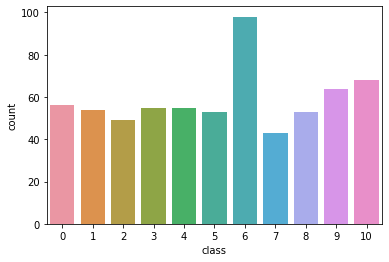

In [5]:
Y = train.drop(labels = ["file_name"], axis = 1)
X = train.drop(labels = ["class"], axis = 1)


(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y)
#X는 file_name
#Y는 class index 
del train

g = sns.countplot(Y_train["class"])

Y_train["class"].value_counts()
#Y_test.value_counts()

In [6]:
print(Y_train)

     Unnamed: 0  class
653         653      8
267         267      3
801         801     10
634         634      8
465         465      6
..          ...    ...
534         534      6
584         584      7
493         493      6
527         527      6
168         168      2

[648 rows x 2 columns]


In [ ]:
for file, label in zip(X_train["file_name"], Y_train["class"]):
  print(file, label) # file_name

In [8]:
def load_data(fileset, labelset):

    datasets = os.path.join(drive_dir, "colab", "CNU_AI_TEAMWORK", "Term_Dataset", "train") 
    # 여기에 파일들이 있음
    output = []
    images = []
    labels = []
    
    # Iterate through each image in our folder
    for file, label in tqdm(zip(fileset["file_name"], labelset["class"])):
        
        # Get the path name of the image
        img_path = os.path.join(os.path.join(datasets, file))
        
        # Open and resize the img
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMAGE_SIZE) 
        
        # Append the image and its corresponding label to the output
        images.append(image)
        labels.append(label)
            
    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')   
      
    return (images, labels)

Load Data

In [9]:
(train_images, train_labels) = load_data(X_train, Y_train)
(test_images, test_labels) = load_data(X_test, Y_test)

648it [10:22,  1.04it/s]
216it [03:40,  1.02s/it]


In [10]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)
#random_state 모르겠음

In [11]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

# 75 : 25로 split

Number of training examples: 648
Number of testing examples: 216
Each image is of size: (150, 150)


*** 여기까지 정상 동작***

[Base this code](https://www.kaggle.com/code/vincee/intel-image-classification-cnn-keras/notebook)


--------------------------

# Show dataset

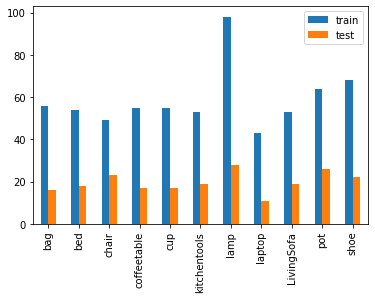

In [12]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)
pd.DataFrame({'train': train_counts, 'test': test_counts}, index = class2index.keys()).plot.bar()
plt.show()

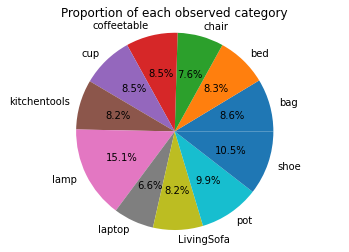

In [14]:
plt.pie(train_counts,
        explode=(0,0,0,0,0,0,0,0,0,0,0),
        labels=class2index.keys(), # label은 class2index의 key
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

# **Normalization !** 
*scale the data*


In [15]:
train_images = train_images / 255.0
test_images = test_images / 255.0


#Visualize the data

In [16]:
def display_random_image(class_names, images, labels): # class_names : dict
  """
    Display a random image from the images array and its correspond label from the labels array.
  """

  index = np.random.randint(images.shape[0])
  plt.figure()
  plt.imshow(images[index])
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.title('Image #{} : '.format(index) + class_names[labels[index]])
  plt.show()

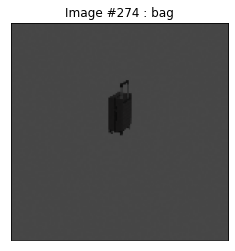

In [21]:
class_names = list(class2index.keys())
display_random_image(class_names, train_images, train_labels)

*** 여기까지 정상 동작***

[Base this code](https://www.kaggle.com/code/vincee/intel-image-classification-cnn-keras/notebook)

#Modeling 부터 이어서!

---------------------